In [ ]:
# %load_ext autoreload
# %autoreload 1

## Setup

In [ ]:
# import os, sys, warnings, json, glob, tables
# from pathlib import Path
# from functools import partial

# import numpy as np, pandas as pd
# import seaborn as sns
# from datetime import datetime as dt, timedelta as td
# import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation
# import pathlib
# import random
# import time
# import scipy
# from matplotlib.colors import LinearSegmentedColormap
# from IPython.display import Video
# from fractions import Fraction
# plt.rcParams["animation.html"] = "jshtml"
# path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
# if path not in sys.path:
#     sys.path.insert(0,path)
# import config
# import utils
# from utils import cv_from_binary
# sys.path[:3]

In [ ]:
#sys.path.insert(0,str(Path(os.path.join('src','elohim')).absolute()))
#print(sys.path)
#%aimport analyzer

## Loading lastly recorded simulation instance

In [1]:
import os, json, glob, re
import numpy as np
ds = [d for d in sorted(os.scandir(os.path.join('..','history')), key=lambda x:x.path, reverse=False) if re.match(r'(.*?)[0-9]{4}-[0-9]{6}', d.path) is not None]
print([d.path for d in ds])
d = ds[-1]
print(f'The most recent simulation folder has been selected "{d.path}":')
points_file = os.path.join(d.path, 'points.json')
assert os.path.exists(points_file)
with open(points_file) as f:
    points = json.load(f)
targets = np.array([[t["x"], t["y"]] for t in points["targets"]])
fp_files = glob.glob(f'{d.path}/*.h5')
files = [os.path.basename(x) for x in fp_files]
files

['../history/1205-002637']
The most recent simulation folder has been selected "../history/1205-002637":


['head_camera_image_raw.h5',
 'virtual_sensor_signal.h5',
 'odom.h5',
 'ground_truth_odom.h5',
 'run_counter.h5']

What are the obstacles coordinates in this specific simulation instance?

(648, 2)

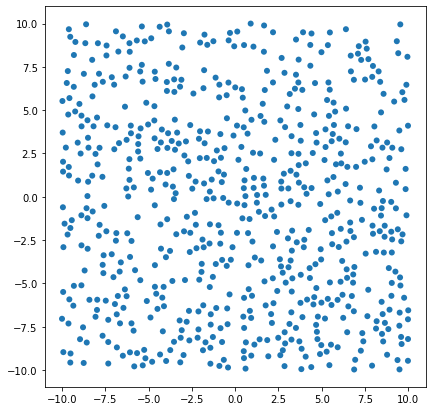

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
points_file = os.path.join(d.path, 'points.json')
with open(points_file) as f:
    points_d = json.load(f)
points = np.array([(c['x'],c['y']) for c in points_d['targets']])
display(points.shape)
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x=points[:,0], y=points[:,1], edgecolor='none')
ax.set_aspect('equal')
plt.show();

Let's move everything from hdf5 to pandas, while taking the necessary precaution in case the custom rosbag was still appending data

In [3]:
import warnings, time
import pandas as pd, tables

assert len(files) >= 4
print('Preparing dataset..', end=' ')
last_snapshot = {}
while len(last_snapshot) == 0:
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=tables.PerformanceWarning)
            last_snapshot = {}
            for ff in fp_files:
                last_snapshot[ff] = pd.read_hdf(ff)
    except ValueError:
        print(f'No dataset in HDF5 file: {ff}')
        exit()
    except Exception:
        print("Recorder is probably locking the file, trying again in 3 second")
        time.sleep(3)
print('Done')
display(pd.concat([last_snapshot[i].head(1).reset_index(drop=True) for i in fp_files], axis=1))


Preparing dataset.. Done


image  sensor         x  \
0  NUMPY v {'descr': '|u1', 'fortran_order': Fa...    0.12  0.063023   

          y     theta         x         y     theta  run  
0  0.000962  0.012093  2.415329  9.980537 -2.912663    1

### Let's merge dataframes of data from different sensors

In [4]:
import analyzer, importlib
from analyzer import mergedfs
importlib.reload(analyzer)
df = mergedfs(last_snapshot)
print(f'Unique runs: {len(df["run"].unique())}')
df.head()

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


head_camera_image_raw.h5  296180
virtual_sensor_signal.h5  270051
odom.h5                   296387
ground_truth_odom.h5      296282
run_counter.h5            351855
Resulting length: 270051. Total discarded records: 10.6% (160500/1510755).
Unique runs: 975


sensor  \
time                                    
2020-12-04 23:26:38.133996084    0.12   
2020-12-04 23:26:38.265870027    0.12   
2020-12-04 23:26:38.401317797    0.12   
2020-12-04 23:26:38.540805608    0.12   
2020-12-04 23:26:38.685717279    0.12   

                                                                           image  \
time                                                                               
2020-12-04 23:26:38.133996084  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.265870027  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.401317797  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.540805608  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.685717279  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   

                                      x         y     theta  \
time                                                          
2020-12-04 23:26:38.133996084  0.063023  0.000962  0.012093   
2020-12-04 23:26:38.265870027  0.077871  0.001139  0.011676   
2020-12-04 23:26:38.401317797  0.092720  0.001309  0.011259   
2020-12-04 23:26:38.540805608  0.107569  0.001473  0.010843   
2020-12-04 23:26:38.685717279  0.122418  0.001631  0.010427   

                               ground_truth_odom_x  ground_truth_odom_y  \
time                                                                      
2020-12-04 23:26:38.133996084             2.415329             9.980537   
2020-12-04 23:26:38.265870027             2.400870             9.977172   
2020-12-04 23:26:38.401317797             2.386409             9.973813   
2020-12-04 23:26:38.540805608             2.371948             9.970459   
2020-12-04 23:26:38.685717279             2.357485             9.967111   

                               ground_truth_odom_theta  run  
time                                                         
2020-12-04 23:26:38.133996084                -2.912663    1  
2020-12-04 23:26:38.265870027                -2.913043    1  
2020-12-04 23:26:38.401317797                -2.913422    1  
2020-12-04 23:26:38.540805608                -2.913801    1  
2020-12-04 23:26:38.685717279                -2.914179    1

In [41]:
#sns.histplot(data=df.groupby('run').apply(lambda x: x['sensor'].sum()*100/len(df)));

In [42]:
# import os, pandas as pd, numpy as np
# sample = df['image'].iloc[0]

# for index in [False]:
#     if os.path.exists('DELETE_ME.h5'):
#         os.remove('DELETE_ME.h5')
#     times = []
#     for i in range(100):
#         n = int(np.random.randint(500,1000,size=1))
#         df = pd.DataFrame({'image':[sample]*n}, index=pd.date_range('00:00:00','00:05:00', periods=n))
#         start = time.time()
#         df.to_hdf('DELETE_ME.h5', 'test', append=True, index=index)
#         #with pd.HDFStore('DELETE_ME.h5') as store:
#         #   store.append('test', df, index=index)#, min_itemsize=20000)
#         times.append(time.time() - start)
    
# pd.read_hdf('DELETE_ME.h5', key='test', mode='r')

In [43]:
# import seaborn as sns
# sns.lineplot(data=times, label=str(index));

### Before starting to process data, we need a quick tool to visually check any particular simulation run that shows odd statistics

In particular, let's use the camera feed, imshow funcanim should be quick enough

In [5]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from fractions import Fraction
import pathlib
from IPython.display import Video

import sys
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
from utils import cv_from_binary

def show_camera_feed(df, run_id=None, folder=None, rate=30, s=None):
    if run_id is None:
        data = df[['image','sensor']].copy()
    else:
        data = df[df['run'] == run_id][['image','sensor']].copy()
        
    if s is not None:
        data = data.iloc[s]
    
    if len(data) == 0:
        return
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=rate, metadata=dict(artist='Me'), bitrate=1800)
    images = data['image'].map(cv_from_binary).map(Image.fromarray, "RGB").values
    
    matplotlib.rcParams['animation.embed_limit'] = images.nbytes * 13215
    frac = Fraction(*config.camera_shape[:2][::-1])
    fig, ax = plt.subplots(figsize=(frac.numerator*2,frac.denominator*2))
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    feed_frame = ax.imshow(images[0])
    
    sensor_data = data['sensor'].round(3).astype(str).values
    sensor = ax.text(0.1,0.1, s=sensor_data[0], weight='bold', color='white', size=25, transform=ax.transAxes)
    def init():
        feed_frame.set_data(images[0])
        sensor.set_text(sensor_data[0])
        return feed_frame, sensor,
    def animate(i):
        feed_frame.set_data(images[i])
        sensor.set_text(sensor_data[i])
        return feed_frame, sensor,
    ani = FuncAnimation(fig, animate, frames=len(images), interval=1000. / rate, blit=True, init_func=init, repeat=True)
    plt.close()
    
    if folder is None:
        folder = '.'
    folder = os.path.join(folder, 'single_runs')
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(folder,f'run_{str(run_id).zfill(3)}.mp4')
    ani.save(file_path, writer=writer, progress_callback=lambda i, n: print(f'\rProgress: {(i+1) * 100. / n:.2f} %', end=''))
    print(f'\rComplete! Video file saved to {file_path}')
    return Video(file_path)

# Analysis

In [6]:
import config
df['obstacle_near'] = df['sensor'] != config.max_sensor_threshold
display(df['sensor'].min())
df

0.010286598466336727

sensor  \
time                                    
2020-12-04 23:26:38.133996084    0.12   
2020-12-04 23:26:38.265870027    0.12   
2020-12-04 23:26:38.401317797    0.12   
2020-12-04 23:26:38.540805608    0.12   
2020-12-04 23:26:38.685717279    0.12   
...                               ...   
2020-12-05 09:17:55.130332570    0.12   
2020-12-05 09:17:55.248734094    0.12   
2020-12-05 09:17:55.370205987    0.12   
2020-12-05 09:17:55.488253646    0.12   
2020-12-05 09:17:55.606988069    0.12   

                                                                           image  \
time                                                                               
2020-12-04 23:26:38.133996084  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.265870027  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.401317797  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.540805608  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:38.685717279  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
...                                                                          ...   
2020-12-05 09:17:55.130332570  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.248734094  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.370205987  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.488253646  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.606988069  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   

                                         x           y     theta  \
time                                                               
2020-12-04 23:26:38.133996084     0.063023    0.000962  0.012093   
2020-12-04 23:26:38.265870027     0.077871    0.001139  0.011676   
2020-12-04 23:26:38.401317797     0.092720    0.001309  0.011259   
2020-12-04 23:26:38.540805608     0.107569    0.001473  0.010843   
2020-12-04 23:26:38.685717279     0.122418    0.001631  0.010427   
...                                    ...         ...       ...   
2020-12-05 09:17:55.130332570  1754.008179 -692.656673  2.877333   
2020-12-05 09:17:55.248734094  1753.993850 -692.652793  2.876977   
2020-12-05 09:17:55.370205987  1753.965197 -692.645018  2.876265   
2020-12-05 09:17:55.488253646  1753.950873 -692.641123  2.875908   
2020-12-05 09:17:55.606988069  1753.950873 -692.641123  2.875908   

                               ground_truth_odom_x  ground_truth_odom_y  \
time                                                                      
2020-12-04 23:26:38.133996084             2.415329             9.980537   
2020-12-04 23:26:38.265870027             2.400870             9.977172   
2020-12-04 23:26:38.401317797             2.386409             9.973813   
2020-12-04 23:26:38.540805608             2.371948             9.970459   
2020-12-04 23:26:38.685717279             2.357485             9.967111   
...                                            ...                  ...   
2020-12-05 09:17:55.130332570            10.055767             5.319260   
2020-12-05 09:17:55.248734094            10.069135             5.325701   
2020-12-05 09:17:55.370205987            10.082505             5.332138   
2020-12-05 09:17:55.488253646            10.095877             5.338570   
2020-12-05 09:17:55.606988069            10.109251             5.344998   

                               ground_truth_odom_theta  run  obstacle_near  
time                                                                        
2020-12-04 23:26:38.133996084                -2.912663    1          False  
2020-12-04 23:26:38.265870027                -2.913043    1          False  
2020-12-04 23:26:38.401317797                -2.913422    1          False  
2020-12-04 23:26:38.540805608                -2.913801    1          False  
2020-12-04 23:26:38.685717279                -2.914179    1          False  
... 

Let's remove all runs that are too short to even build a single occupancy map

In [22]:
import config

window = '20s'
df = df.groupby('run').filter(lambda x: (x.index[-1]-x.index[0]) > pd.Timedelta(window))
df = df[df['run'] != -1]

Let's label 'out of map' runs

In [23]:
df = df.groupby("run").apply(lambda x: x.assign(out_of_map=
            True if (x[[f"ground_truth_odom_{a}" for a in ["x","y"]]].iloc[-1].abs() > config.plane_side/2).any()
            else False)).reset_index(level=0, drop=True)

In [24]:
df

sensor  \
time                                    
2020-12-04 23:26:39.487677108    0.12   
2020-12-04 23:26:39.610342124    0.12   
2020-12-04 23:26:39.728089117    0.12   
2020-12-04 23:26:39.853063883    0.12   
2020-12-04 23:26:39.979601239    0.12   
...                               ...   
2020-12-05 09:17:55.130332570    0.12   
2020-12-05 09:17:55.248734094    0.12   
2020-12-05 09:17:55.370205987    0.12   
2020-12-05 09:17:55.488253646    0.12   
2020-12-05 09:17:55.606988069    0.12   

                                                                           image  \
time                                                                               
2020-12-04 23:26:39.487677108  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:39.610342124  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:39.728089117  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:39.853063883  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-04 23:26:39.979601239  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
...                                                                          ...   
2020-12-05 09:17:55.130332570  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.248734094  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.370205987  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.488253646  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   
2020-12-05 09:17:55.606988069  NUMPY v {'descr': '|u1', 'fortran_order': Fa...   

                                         x           y     theta  \
time                                                               
2020-12-04 23:26:39.487677108     0.211512    0.002449  0.007933   
2020-12-04 23:26:39.610342124     0.226362    0.002564  0.007518   
2020-12-04 23:26:39.728089117     0.241211    0.002672  0.007102   
2020-12-04 23:26:39.853063883     0.256061    0.002775  0.006687   
2020-12-04 23:26:39.979601239     0.270910    0.002871  0.006272   
...                                    ...         ...       ...   
2020-12-05 09:17:55.130332570  1754.008179 -692.656673  2.877333   
2020-12-05 09:17:55.248734094  1753.993850 -692.652793  2.876977   
2020-12-05 09:17:55.370205987  1753.965197 -692.645018  2.876265   
2020-12-05 09:17:55.488253646  1753.950873 -692.641123  2.875908   
2020-12-05 09:17:55.606988069  1753.950873 -692.641123  2.875908   

                               ground_truth_odom_x  ground_truth_odom_y  \
time                                                                      
2020-12-04 23:26:39.487677108             2.270681             9.947135   
2020-12-04 23:26:39.610342124             2.256210             9.943825   
2020-12-04 23:26:39.728089117             2.241737             9.940520   
2020-12-04 23:26:39.853063883             2.227263             9.937221   
2020-12-04 23:26:39.979601239             2.212787             9.933928   
...                                            ...                  ...   
2020-12-05 09:17:55.130332570            10.055767             5.319260   
2020-12-05 09:17:55.248734094            10.069135             5.325701   
2020-12-05 09:17:55.370205987            10.082505             5.332138   
2020-12-05 09:17:55.488253646            10.095877             5.338570   
2020-12-05 09:17:55.606988069            10.109251             5.344998   

                               ground_truth_odom_theta  run  obstacle_near  \
time                                                                         
2020-12-04 23:26:39.487677108                -2.916446    1          False   
2020-12-04 23:26:39.610342124                -2.916824    1          False   
2020-12-04 23:26:39.728089117                -2.917201    1          False   
2020-12-04 23:26:39.853063883                -2.917579    1          False   
2020-12-04 23:26:39.979601239                -2.917956    1          False 

Let's check that we are correctly labeling run that end with 'out of map' scenarios

In [25]:
def statistics(df):
    print(f'Unique runs: {len(df["run"].unique())}')
    print(f'Out of map runs: {len(df.groupby("run").filter(lambda x: x["out_of_map"].any())["run"].unique())*100/len(df["run"].unique()):2.0f}%')
    s0, s1, s2 = df["obstacle_near"], df.loc[df["out_of_map"],"obstacle_near"], df.loc[~df["out_of_map"],"obstacle_near"]
    perc = lambda x: x.astype(int).sum()*100/len(df)
    print(f'Obstacle detection readings - Total: {perc(s0):2.1f}%,\nOut Of Map scenarios total obstacle readings: {perc(s1):2.1f}%,\nObstacle scenarios total: {perc(s2):2.1f}%')
    print(f'Average % of obs. detection readings per run: {df[~df["out_of_map"]].groupby("run")["obstacle_near"].apply(lambda x: x.sum()/len(x)).mean()*100:2.2f}%')  
statistics(df)

Unique runs: 790
Out of map runs: 10%
Obstacle detection readings - Total: 19.9%,
Out Of Map scenarios total obstacle readings: 0.3%,
Obstacle scenarios total: 19.7%
Average % of obs. detection readings per run: 25.69%


In [20]:
random_run = np.random.choice(df.loc[~df['out_of_map'],'run'].unique())
show_camera_feed(df, random_run, s=slice(-100, None, None))

Complete! Video file saved to ./single_runs/run_701.mp4


(-2.0, 20.0)

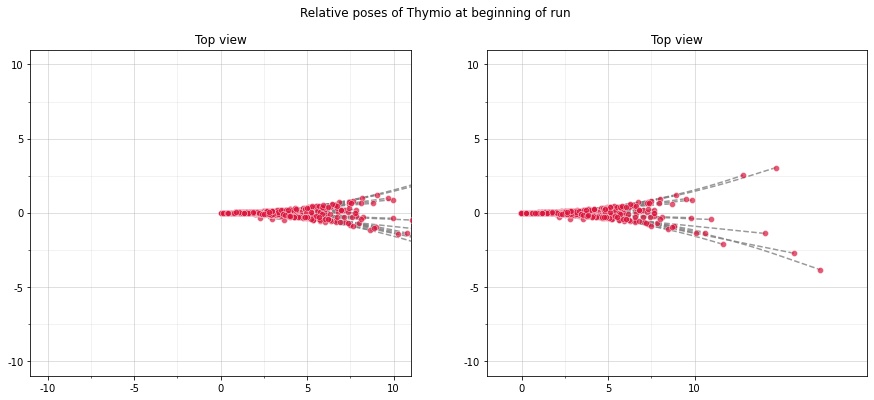

In [26]:
import seaborn as sns
def setup_topview(ax):
    half_side = config.plane_side // 2
    bounds = [-half_side - 1, half_side + 1]
    ax.set(title="Top view", xlim=bounds, ylim=bounds, autoscale_on=False, adjustable='box')
    major_ticks = np.arange(-half_side, half_side + 1, 5)
    minor_ticks = np.arange(-half_side, half_side + 1, 2.5)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

def plot_relative_runs(df, ax):

    input_cols = [f'ground_truth_odom_{axis}' for axis in ['x', 'y', 'theta']]
    output_cols = ['gt_rel_' + label.rsplit('_', 1)[-1] for label in input_cols]
    df = df.copy()
    def rotate(p):
        angle = -p.iat[0,-1]
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        p[input_cols] = p - p.iloc[0]
        p[input_cols[:2]] = np.squeeze((R @ p.loc[:,input_cols[:2]].T).T).values
        return p

    df[output_cols] = df.groupby('run')[input_cols].apply(rotate)

    setup_topview(ax)
    def show_proof(run):
        x,y,t = run[output_cols].values.T
        sns.lineplot(x=x,y=y, linestyle='--', alpha=0.8, color='grey', ax=ax)
        sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=0.7, color='crimson', ax=ax, legend=False, zorder=3)
        sns.lineplot(x=[x[0], x[0]+np.cos(t[0])*2],y=[y[0], y[0]+np.sin(t[0])*2], color='black', ax=ax)

    df.groupby('run').apply(show_proof)

fig, axes = plt.subplots(1, 2, figsize=(15,6))
plot_relative_runs(df, axes[0])
reduced = df.groupby('run').apply(lambda x: x.iloc[10:]).reset_index(level=0, drop=True)
plot_relative_runs(reduced, axes[1])

plt.suptitle('Relative poses of Thymio at beginning of run')
axes[1].set_xlim(-2,20)

Let's cut the first 10 iteration to be sure we do not include any precedent run data

In [27]:
df = reduced
df = df.groupby('run').filter(lambda x: (x.index[-1]-x.index[0]) > pd.Timedelta(window))
statistics(df)

Unique runs: 771
Out of map runs:  9%
Obstacle detection readings - Total: 20.4%,
Out Of Map scenarios total obstacle readings: 0.3%,
Obstacle scenarios total: 20.2%
Average % of obs. detection readings per run: 26.48%


### Controlliamo la qualità delle run registrate, hanno tutte senso?

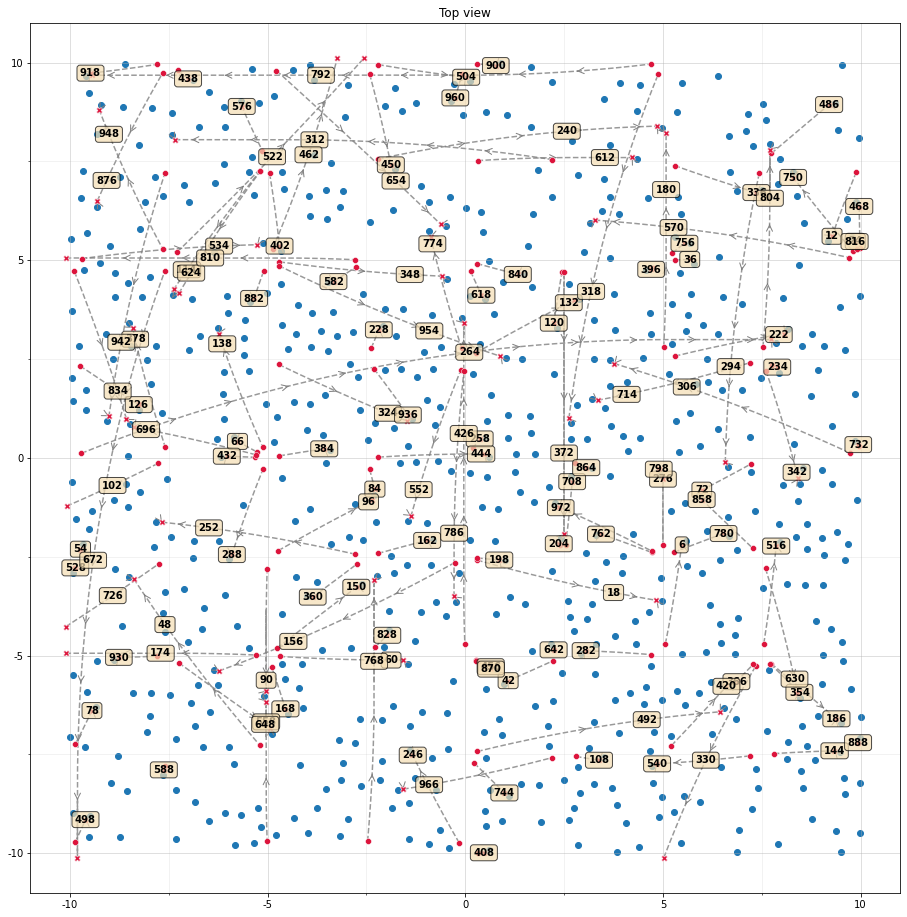

In [28]:
import importlib
import utils
from utils import add_arrow
from functools import partial
importlib.reload(utils)

fig, ax = plt.subplots(figsize=(16,16))

setup_topview(ax)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
def plot_traces(run, full=True):
    if not full and run.iloc[0]['run']%6 != 0:
        return
    x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
    sns.lineplot(x=x,y=y, linestyle='--', alpha=0.8, color='grey', ax=ax, zorder=1)
    add_arrow(ax.lines[-1], x, y, step=100)

    sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4)
    sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4, markers=['X'])
    ax.text(x[int(len(x)*0.5)],y[int(len(y)*0.5)],s=run.iloc[0]['run'],
            horizontalalignment='center', verticalalignment='center', bbox=props,  weight='bold', zorder=5)

df.groupby('run').apply(partial(plot_traces, full=False))
ax.scatter(x=points[:,0], y=points[:,1])
ax.set_aspect('equal');

In [29]:
from datetime import timedelta as td
run_lengths_time = df.groupby('run').apply(lambda x: (x.index[-1] - x.index[0])).sort_values()
run_lengths_time

run
908   00:00:20.025329
5     00:00:20.026988
851   00:00:20.032602
676   00:00:20.057652
172   00:00:20.070345
            ...      
917   00:01:56.102760
672   00:02:00.258812
792   00:02:12.625129
315   00:02:28.572997
264   00:02:43.430755
Length: 771, dtype: timedelta64[ns]


## Occupancy Map


In [30]:
coords = np.stack(np.meshgrid(
    np.linspace(0, .8, int(.8 / .04)),
    np.linspace(-.4, .4, int(.8 / .04))
)).reshape([2, -1]).T
display(coords.shape)
#sns.scatterplot(x=coords[:,0], y=coords[:,1]);

(400, 2)

In [31]:
import occupancy_map
importlib.reload(occupancy_map)
from occupancy_map import compute_occupancy_map


In [33]:
import occupancy_map 
importlib.reload(occupancy_map)
from occupancy_map import compute_occupancy_map
import analyzer
importlib.reload(analyzer)
from analyzer import Animator

delta = 0.025

## 5 interesting
random_run = np.random.choice(df.loc[~df['out_of_map'],'run'].unique(), 5)
## 1 out of map
random_run = np.append(random_run, np.random.choice(df.loc[df['out_of_map'],'run'].unique()))

for r in random_run:
    run = df[df['run'] == r].copy()
    omap = run.apply(compute_occupancy_map, axis=1, args=(run, coords, ['sensor'], window, delta))
    run = pd.concat([run, omap], axis=1)
    save_path = os.path.join(d.path,'single_runs',f'omap_{r}.mp4')
    Animator(run, targets, rate=30, save_path=save_path, extra_info={'Time window':window, ' delta': delta})
    display(Video(save_path))

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Process complete. Video file saved to: ../history/1205-002637/single_runs/omap_520.mp4


Process complete. Video file saved to: ../history/1205-002637/single_runs/omap_399.mp4


Looks healthy, process the whole dataset

In [ ]:
occ_map = df.groupby('run').progress_apply(lambda x: x.apply(compute_occupancy_map, axis=1, args=(x, coords, ['sensor'], window, delta)))
if 'target_map' in df.columns:
    df['target_map'] = occ_map
else:
    df = pd.concat([df, occ_map],axis=1)

 63%|██████▎   | 506/808 [1:13:41<54:59, 10.93s/it]  

In [ ]:
r = 2
run = df[df['run'] == r].copy()
save_path = os.path.join(d.path,'single_runs',f'omap_{r}.mp4')
Animator(run, targets, rate=30, save_path=save_path, extra_info={'Time window':window, ' delta': delta})
display(Video(save_path))

In [ ]:
(df['sensor'] == 0.12).value_counts(normalize=True)*100

In [ ]:
df['out_of_map'].value_counts(normalize=True)*100

In [ ]:
#dataset = df.loc[~df['out_of_map'],['run','image','target_map']].reset_index(drop=True).copy()
df.to_pickle(os.path.join(d.path, 'dataset.pkl'))
#del dataset

In [ ]:
import scipy
from matplotlib.colors import LinearSegmentedColormap
from utils import mktransf
def plot_last_omap(df, run_id):
    if 'target_map' not in df.columns:
        print('No occupancy maps')
        return
    run = df[df['run'] == run_id].copy()
    run['gt_pose'] = run[['ground_truth_odom_x', 'ground_truth_odom_y', 'ground_truth_odom_theta']].apply(mktransf, axis=1)

    def plot_transform(ax, tr, color='b', length=1, debug=False):
        origin = (tr @ np.array([0, 0, 1]))[:2]
        xhat   = (tr @ np.array([length, 0, 1]))[:2]
        yhat   = (tr @ np.array([0, 0, 1]))[:2] #(tr @ np.array([0, length, 1]))[:2]

        ax.arrow(*origin, *(xhat - origin), head_width=0.005, color=color, zorder=3)
        ax.arrow(*origin, *(yhat - origin), head_width=0.005, color=color,zorder=3, alpha=0.02)

    fix, axes = plt.subplots(1,2, figsize=(10,5))
    #fig.tight_layout(w_pad=0.1)
    plt.subplots_adjust(top=0.9,wspace=0.1)
    
    ax = axes[1]
    omap = run.iloc[-1]['target_map']
    
    myColors = ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data=omap.reshape(20,20), ax=ax, cmap=cmap, linecolor='lightgray')
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['unknown', 'obstacle', 'no obstacle'])
    
    ax.arrow(0.1,0.5, 0, 0.3, color='white', head_width=0.02, transform=ax.transAxes)
    ax.arrow(0.1,0.5, 0.3, 0, color='white', head_width=0.02, transform=ax.transAxes)

    #ax.arrow(0,0, , head_width=0.005, color=color,zorder=3, alpha=0.02)
    ax.set_title('Last occupancy map')
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    
    ax = axes[0]
    #setup_topview(ax)
    for a in run['gt_pose'].values[-100::1]:
        plot_transform(ax, a, color='b',length=0.10)
    ax.set_title('Top view of poses')
    
    x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
    sns.lineplot(x=x[-20:],y=y[-20:], linestyle='--', alpha=0.8, color='grey', ax=ax, zorder=1)
    #add_arrow(ax.lines[-1], x[-20:], y[-20:], step=200)

    #sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=2, s=200, label='Start')
    x_last,y_last=x[-1:],y[-1:]
    sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4, markers=['X'], s=200, label='Stop')
    
    obst = points[scipy.spatial.distance.cdist( points, np.array([x_last, y_last]).T ).argmin()]
    #ax.scatter(x=obst[0], y=obst[1], s=200, color='crimson')
    
    ax.add_artist(plt.Circle(obst, radius=0.08, facecolor='red', linestyle='--', alpha=0.5))
    ax.add_artist(plt.Circle(obst, radius=0.3, facecolor='none', edgecolor='black', linestyle='--', alpha=0.5))
    ax.add_artist(plt.Circle(obst, radius=0.1, facecolor='none', edgecolor='black', linestyle='--'))

    extent = 0.3
    #ax.set_xlim(x_last[0]-extent,x_last[0]+extent)
    ax.set_xlim(ax.get_xlim()[0]-extent, ax.get_xlim()[1]+extent)
    ax.set_ylim(y_last[0]-extent,y_last[0]+extent)
    ax.set_aspect('equal')

    #plt.autoscale(enable=True, axis='both', tight=None)
    plt.suptitle(f'Final part of run #{run_id}')
    
plot_last_omap(run_id=119)

In [ ]:
import matplotlib.patches as patches
n = 16
subset = np.random.choice(df['run'].unique(),n)
plt.close()
fig, axs = plt.subplots(4,4, figsize=(10,10))
run_axs = {s:ax for s, ax in zip(subset, np.array(axs).flatten())}
target_runs = df[df['run'].isin(subset) & df['meaningful_omap'].any()]# & df['meaningful_omap'].any() & ()]
def plotter(x):
    run_id = x.iloc[0]['run']
    ax = run_axs[run_id]
    omap = x.loc[x['meaningful_omap'][::-1].idxmax(),'target_map']
    sns.heatmap(data=omap.reshape(20,20), ax=ax, cbar=False)

    ax.axis('off'), ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False)
    ax.add_patch(patches.Rectangle((0.,0.),1,1, linewidth=5, edgecolor='white', facecolor='none', transform=ax.transAxes))
    ax.text(0.5,0.1, s=str(run_id), transform=ax.transAxes, weight='bold', color='white', size=15, horizontalalignment='center', verticalalignment='center')

target_runs.groupby('run').apply(plotter)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.show();

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import numpy as np
fig = plt.figure(figsize=(10,7.5))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[20,1], height_ratios=[1])
ax = plt.subplot(111)

## data
xx = np.linspace(1,100,num=100) + 20 * np.random.normal(0,1,100)
yy = np.linspace(1,100,num=100) + 10 * np.random.normal(0,1,100)

## scatter
sc = ax.scatter(xx, yy, s=250, alpha=0.35, zorder=100)
ax.plot(np.linspace(-100,200,301), np.linspace(-100,200,301),)
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.grid(linestyle="--", zorder=10)

## zoom
axins = zoomed_inset_axes(ax, 2, loc="upper left")
scins = axins.scatter(xx, yy, s=100, alpha=0.35, zorder=50, marker=".", c="red")
axins.plot(np.linspace(-100,200,301), np.linspace(-100,200,301), c="red")
axins.set_xlim((70, 90))
axins.set_ylim((70, 90))
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
axins.grid(linestyle="--", zorder=50)
plt.show()

In [ ]:
# sns.histplot(data=df.groupby('run').apply(lambda x: x['sensor'].astype(int).sum()*100/len(x)));

In [ ]:
# def f(x):
#     x = x[5:]
#     multiplier = 2.
#     coeff = (x.index[-1]-x.index[0]).nanoseconds/len(x)
#     diff = x['ground_truth_odom_theta'].diff() * coeff
#     mask = diff.fillna(0).between(-0.1, 0.1)
    
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     #assert(blocks.value_counts()
    
#     x['rotating'] = False
#     if len(blocks.unique()) >= 2:
#         x.loc[(blocks == 2).idxmax():, 'rotating'] = True
#     return x
# df2 = df.groupby('run').apply(f).reset_index(level=0,drop=True)
# statistics(df2)
# df2 = df2.groupby('run').apply(lambda x: x.assign(out_of_map=True if x['rotating'].any() else False))
# df2

In [ ]:
# Analyze theta instead
# df = df.groupby('run').apply(lambda x: x.assign(out_of_map=True if x['sensor'].astype(int).sum() == 0 else False)).reset_index(level=0, drop=True)
# print(f'% of runs that ended out of map: {len(df.groupby("run").filter(lambda x: x.iloc[0]["out_of_map"])["run"].unique())*100/len(df["run"].unique()):2.2f}%')

Histogram of sensor readings per run, normalized over run length

## Time analysis - How long does a run usually last

In [ ]:
from datetime import datetime as dt
today = dt.today().replace(hour=0,minute=0,second=0, microsecond=0)
fig, ax = plt.subplots(figsize=(35,2))
def test(x):
    x = x.copy()
    x.index -= x.index[0] - today
    sns.lineplot(data=x, alpha=0.3, ax=ax)
    sns.scatterplot(data=x.iloc[-1:], color=ax.lines[-1].get_color(), ax=ax)
    
df.groupby('run')['sensor'].apply(test);

In [ ]:
run_lengths_iter = df.groupby('run')['x'].count().sort_values()
run_lengths_iter

Nanoseconds per iteration on every run

In [ ]:
df.groupby('run').apply(lambda x: (x.index[-1] - x.index[0])/len(x)).sort_values().dt.nanoseconds

Runs sorted by biggest timestamp diff on adjacent iterations

In [ ]:
run_time_diff = df.groupby('run').apply(lambda x: np.diff(x.index).max()).sort_values()
run_time_diff

Shouldn't it be 38 seconds? Why the hiccup at the end?

In [ ]:
# longest_run = 79
# show_camera_feed(df, run_id=longest_run)

## Hiccup analysis

In [ ]:
# norm = np.linalg.norm(df[df['run'] == longest_run][['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1)
# display(np.diff(norm).max())
# sns.lineplot(data=norm);

Let's find those hiccups and fix them

In [ ]:
# from functools import partial
# def clean_runs_median(multiplier, x):
#     x = x[1:]
#     norm = pd.Series(np.linalg.norm(x[['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1), index=x.index)
#     diff = norm.diff()
#     med = diff.median()
#     MAD = (med - diff.fillna(med)).abs().median()
#     mask = diff.between(med-MAD*multiplier, med+MAD*multiplier)
#     #return pd.DataFrame({'run':x['run'], 'diff':diff,'mask': mask, 'sensor': x['sensor'], 'med':med,  'mad':mad}, index=x.index)
#     if (~mask).any():
#         blocks = (mask.shift() != mask).cumsum().astype(int)
#         if len(blocks[mask]) > 0:
#             shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#             if len(shrinked) > config.window_size:
#                 return shrinked
#     else:
#         return x

# test = df.groupby('run').apply(lambda x: x.iloc[3:]).reset_index(level=0, drop=True).groupby('run').apply(partial(clean_runs_median, 3.)).reset_index(level=0, drop=True)
# statistics(test)
# random_run_id = np.random.choice(test['run'].unique())
# test.loc[test['run'] == 79].tail(30)#319

In [ ]:
# show_camera_feed(test, run_id=319)

In [ ]:
# x = df[df['run'] == 79].iloc[1:].copy()
# multiplier = 3.
# display(len(x))
# norm = pd.Series(np.linalg.norm(x[['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1), index=x.index)
# diff = norm.diff()
# med = diff.median()


In [ ]:
# MAD = (med - diff.fillna(med)).abs().median()
# mask = diff.between(med-MAD*multiplier, med+MAD*multiplier)
# result = None
# if (~mask).any():
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     if len(blocks[mask]) > 0:
#         shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#         if len(shrinked) > config.window_size:
#             result = shrinked
# else:
#     result = x
# display(len(result))
# show_camera_feed(result)

In [ ]:

# # Exclude the still moments after finding an obstacle (mark them as safe)
# #diff_mask = diff.abs() > still_threshold
# med = diff.median()#diff[diff_mask].iloc[1:].median()
# #diff[~diff_mask] = med

# # Absolute median deviation
# mad = (med - diff.fillna(med)).abs().median()

# mask = diff.between(med-mad*multiplier, med+mad*multiplier)
# mask.iloc[0] = mask.iloc[1]
# return pd.DataFrame({'run':x['run'], 'diff':diff,'mask': mask, 'sensor': x['sensor'], 'med':med,  'mad':mad}, index=x.index)
# if (~mask).any():
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     if len(blocks[mask]) > 0:
#         shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#         if len(shrinked) > config.window_size:
#             return shrinked
# else:
#     return x

In [ ]:
#random_run_id = np.random.choice(test['run'].unique())
# print(f'Average % of positive sensor readings per run: {df.groupby("run")["sensor"].apply(lambda x: x.sum()/len(x)).mean()*100:2.2f}%')

#show_camera_feed(test, 119)


In [ ]:
# sizes = []
# r = np.arange(0,60)/10
# for m in r:
#     a = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_x', m)).reset_index(drop=True)
#     if len(a)>0:
#         sizes.append(a.groupby('run')['run'].count().sum())
#     else:
#         sizes.append(0)

In [ ]:
# fig, ax = plt.subplots()
# ax = sns.lineplot(x=r,y=sizes, ax=ax)
# ax = sns.scatterplot(x=r,y=sizes, ax=ax)
# ax.set_xlabel('+-MAD multiplier')
# ax.set_ylabel('Dataset lenght after filtering');
# ax.set_title('Median absolute deviation')
# plt.show();

In [ ]:
def clean_runs_std(label, multiplier, x):
    diff = x[label].diff()
    avg,std = diff.mean(), diff.std()
    mask = diff.fillna(avg).between(avg-std*multiplier,avg+std*multiplier)
    if (~mask).any():
        blocks = (mask.shift() != mask).cumsum().astype(int)
        shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
        if len(shrinked) > config.window_size:
            return shrinked
    else:
        return x

In [ ]:
sizes = []
r = np.arange(0,60)/10
for m in r:
    a = df.groupby('run').apply(partial(clean_runs_std,'ground_truth_odom_y', m)).reset_index(drop=True)
    if len(a)>0:
        sizes.append(a.groupby('run')['run'].count().sum())
    else:
        sizes.append(0)

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(x=r,y=sizes, ax=ax)
ax = sns.scatterplot(x=r,y=sizes, ax=ax)
ax.set_xlabel('+-STD multiplier')
ax.set_ylabel('Dataset lenght after filtering');
ax.set_title('Standard deviation')
plt.show();

The median absolute deviation proves to be a better selector for cleaning the runs

In [ ]:
df = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_x', 2.0)).reset_index(level=0,drop=True)
df = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_y', 2.0)).reset_index(level=0,drop=True)
len(df)

In [ ]:
norm = np.linalg.norm(df[df['run'] == 295][['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1)
display(np.diff(norm).max())
sns.lineplot(data=norm);

### From 0 to 100% of every run, where does the sensor usually activate?

I expect it to activate towards the end of every run

In [ ]:
min_run_length = df.groupby('run')['run'].value_counts().min()
min_run_length

In [ ]:
def linearly_resize(x, resize_window):
    step = (len(x)-1)/(resize_window-1)
    step_indices = np.around(np.cumsum([0]+[step]*resize_window)[:-1]).astype(int)
    return x[step_indices]
linearly_resize(np.arange(100),22)

In [ ]:
fig, ax = plt.subplots( figsize=(25,3))
array = np.array([np.array(x) for x in df.groupby('run')['sensor'].apply(lambda x: linearly_resize(x.values, min_run_length)).values])
sns.lineplot(data=array.sum(axis=0), ax=ax, label='sum')
plt.show()

Why would it activate before than the end?

### Activations before end investigation

In [ ]:
check = df.groupby('run').filter(lambda x: x['sensor'].iloc[:int(len(x)*0.5)].any())
random_run_id = np.random.choice(check['run'].unique())
show_camera_feed(df, random_run_id)

### How many iterations per run?

In [ ]:
fig, ax = plt.subplots( figsize=(20,5))
sns.histplot(data=df.groupby('run').apply(lambda x: len(x)), bins=100, ax=ax);

In [ ]:
run_id = random.choice(df['run'].unique())
show_camera_feed(run_id=run_id, folder=d.path)

How many sensor readings per run?

In [ ]:
sns.histplot(data=df.groupby('run').apply(lambda x:x.loc[x['out_of_map'],'sensor'].sum()));

In [ ]:
# case_study_run = df.groupby('run').apply(lambda x: x['sensor'].sum()).idxmax()
# case_study = df[df['run']==case_study_run].reset_index()
# print(f'Best run ({case_study["sensor"].astype(int).sum()} active out of {len(case_study)}): {case_study_run}, taking last 100 iteration before last positive sensor reading')
# last_sensor_read = case_study['sensor'][::-1].idxmax()
# case_study = case_study.iloc[last_sensor_read-200:last_sensor_read]
# case_study['sensor'].astype(int).plot(marker='o',figsize=(20,1));

In [ ]:
from utils import mktransf
import analyzer
importlib.reload(analyzer)
from analyzer import add_occupancy_maps

df['occupancy_map'] = add_occupancy_maps(df, window_size=config.window_size, empty_value=-2)

In [ ]:
df['meaningful_omap'] = df['occupancy_map'].apply(lambda x: x[0] != -2)
df['meaningful_omap'].value_counts()

Let's remove runs without a single meaningful occ. maps

In [ ]:
df.groupby('run').filter(lambda x: x['meaningful_omap'].astype(int).sum() == 0)

Are the poses computed correctly?

### Mirko omap

In [ ]:
np.unique(np.array([np.array(x) for x in run['target_map'].values]), return_counts=True)

In [ ]:
df.to_hdf(f'{d.path}/unified.h5', key='df', mode='w')

In [ ]:
df['out_of_map']

In [ ]:

def heatmap_animation(run_id):
    images = df.loc[(df['run'] == run_id) & (~df['occupancy_map'].isna()),'occupancy_map'].values
    images = np.array([np.array(x) for x in images]).reshape(-1,20,20)[:10]
    
    fig, ax = plt.subplots(1,2 figsize = (12, 8))
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    feed_frame = feed_frame = ax[1].imshow(images[0])
    x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
    
    def init():
        feed_frame.set_data(images[0])
        return feed_frame,
    def animate(i):
        feed_frame.set_data(images[i])
        return feed_frame,

    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

    #grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}
    plt.close()
    return FuncAnimation(fig = fig, func = animate, init_func=init, frames = len(images), interval = 50, blit = False)

heatmap_animation(run_id=119)

How does the last occupancy map look?

In [ ]:
def adjust_camera_plot(ax):
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

def show_camera_feed(run_id, folder=None, rate=30):
    data = df[df['run'] == run_id]['occupancy_map']
    if len(data) == 0:
        return
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=rate, metadata=dict(artist='Me'), bitrate=1800)
    images = data.map(cv_from_binary).map(Image.fromarray, "RGB").values
    
    matplotlib.rcParams['animation.embed_limit'] = images.nbytes * 13215
    frac = Fraction(*config.camera_shape[:2][::-1])
    fig, ax = plt.subplots(figsize=(frac.numerator*2,frac.denominator*2))
    adjust_camera_plot(ax)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    feed_frame = ax.imshow(images[0])
    def init():
        feed_frame.set_data(images[0])
        return feed_frame,
    def animate(i):
        feed_frame.set_data(images[i])
        return feed_frame,
    ani = FuncAnimation(fig, animate, frames=len(images), interval=1000. / rate, blit=True, init_func=init, repeat=True)
    plt.close()
    
    if folder is None:
        folder = '.'
    folder = os.path.join(folder, 'single_runs')
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(folder,f'run_{str(run_id).zfill(3)}.mp4')
    ani.save(file_path, writer=writer, progress_callback=lambda i, n: print(f'\rProgress: {(i+1) * 100. / n:.2f} %', end=''))
    print(f'\rComplete! Video file saved to {file_path}')
    return Video(file_path)
run_id = 119#random.choice(df['run'].unique())
show_camera_feed(run_id=run_id, folder=d.path)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
setup_topview(ax)
x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
sns.lineplot(x=x,y=y, linestyle='--', alpha=0.8, color='grey', ax=ax, zorder=1)
add_arrow(ax.lines[-1], x, y, step=100)
sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4)
sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4, markers=['X'])
ax.text(x[int(len(x)*0.5)],y[int(len(y)*0.5)],s=run.iloc[0]['run'],
        horizontalalignment='center', verticalalignment='center', bbox=props,  weight='bold', zorder=5)
ax.scatter(x=points[:,0], y=points[:,1])
ax.set_xlim(min(x)+.2, max(x)+.2)
ax.set_ylim(min(y)+.2, max(y)+.2)
ax.set_aspect('equal');

In [ ]:
from analyzer import Animator
save_path = os.path.join(d.path,'single_runs',f'omap_{random_run}.mp4')
Animator(run, targets, rate=30, frames=None, save_path=save_path)
Video(save_path)
# TODO animator with relative poses and translated point

In [ ]:
from analyzer import reset_odom_run
instructions = {'translation': [('ground_truth_odom_x', 'x'),
                                ('ground_truth_odom_y', 'y')],
                'rotation': ('ground_truth_odom_theta', 'theta')}
df2 = reset_odom_run(df, instructions)
df2

In [ ]:
random_run = np.random.choice(df['run'].unique())


In [ ]:
df_check = df[df['run'] == random_run]
df_check['sensor'].astype(int).plot()

## What about odometry?

First let's build the ideal odometry

In [ ]:
input_cols = ['ground_truth_odom_x', 'ground_truth_odom_y', 'ground_truth_odom_theta']
output_cols = ['gt_rel_' + label.rsplit('_', 1)[-1] for label in input_cols]

In [ ]:
before = len(df)
before, len(df.groupby('run').filter(lambda x: x.iloc[-1][output_cols[0]] > 0) or x.iloc[-1][output_cols[1]].between(-2,2)) 

A practical way to discard buggy runs


In [ ]:
after = len(df)
print(f'{before-after} iterations have been removed, reason: buggy runs ({before} -> {after})')